In [400]:
#  Copyright 2022 Institute of Advanced Research in Artificial Intelligence (IARAI) GmbH.
#  IARAI licenses this file to You under the Apache License, Version 2.0
#  (the "License"); you may not use this file except in compliance with
#  the License. You may obtain a copy of the License at
#  http://www.apache.org/licenses/LICENSE-2.0
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.

In [1]:
from IPython.display import display
from IPython.core.display import HTML
%load_ext autoreload
%load_ext time
%autoreload 2
%autosave 60
%matplotlib inline

display(HTML("<style>.container { width:80% !important; }</style>"))

import os
import sys

# Alternatevly, in order to make the module imports work properly set PYTHONPATH=$PWD before launching the notebook server from the repo root folder.
sys.path.insert(0, os.path.abspath("../"))  # noqa:E402

The time module is not an IPython extension.


Autosaving every 60 seconds


In [3]:
import pandas
import geopandas
import numpy as np
import warnings

from collections import namedtuple
from pathlib import Path
from shapely.geometry import LineString

from data_pipeline.h5_helpers import load_h5_file, write_data_to_h5
from data_pipeline.dp01_movie_aggregation import generate_15min_aggregates

from data_pipeline.data_helpers import get_latlon_bounds
from data_pipeline.data_helpers import get_intersecting_grid_cells
from data_pipeline.data_helpers import invert_heading

In [118]:
BASEDIR = Path('/Users/neun/data/t4c/2022_comp_data/prepare_speed_classes')
ROAD_GRAPH_DIR = BASEDIR / 'road_graph'

# city = 'london'
# city = 'madrid'
# city = 'melbourne'
city = 'bla'

### Custom Road Graph

In [120]:
import osmnx as ox

graph_file = ROAD_GRAPH_DIR / 'antwerp' / "road_graph.graphml"
g = ox.load_graphml(graph_file)

In [122]:
len(g.edges)

7263

In [184]:
pandas.read_parquet(ROAD_GRAPH_DIR / 'antwerp' / 'road_graph_nodes.parquet').head()

,node_id,x,y
0,123356,4.341011,51.062823
1,123394,4.344837,51.211919
2,123427,4.152343,51.157899
3,636289,4.444420,51.079332
4,636293,4.441557,51.087871


In [183]:
pandas.read_parquet(ROAD_GRAPH_DIR / 'antwerp' / 'road_graph_geometries.parquet').head()

,u,v,osmid,geometry
0,123356,612541717,"[274849856, 5110916, 274849861, 24231577, 1455...",b'\x01\x02\x00\x00\x00\t\x00\x00\x00\xbdJ\x88\...
1,123394,7994885619,"[1005823809, 270520034, 4314530, 1005823810, 2...","b""\x01\x02\x00\x00\x00\x0c\x00\x00\x00\xd3\xbc..."
2,123427,1595116304,"[146234888, 320849041, 321038796, 320843143]","b""\x01\x02\x00\x00\x00\n\x00\x00\x00\x12\x0f\x..."
3,636289,21280591,"[272837536, 4016281, 27661754, 272837532, 2728...","b""\x01\x02\x00\x00\x00\x06\x00\x00\x00\xe3\xca..."
4,636289,295563837,"[10263815, 10263814, 27661727]","b""\x01\x02\x00\x00\x00\n\x00\x00\x00\xe3\xca4\..."


In [182]:
pandas.read_parquet(ROAD_GRAPH_DIR / 'antwerp' / 'road_graph_edges.parquet').head()

,u,v,speed_kph,highway,oneway,lanes,tunnel,length_meters
0,123356,612541717,120.0,motorway,True,"['3', '2']",nan,849.042
1,123394,7994885619,70.0,motorway,True,"['5', '4']",nan,794.258
2,123427,1595116304,50.0,primary,True,"['3', '1', '4', '2']",nan,349.975
3,636289,21280591,81.2,motorway_link,True,"['1', '2']",nan,566.464
4,636289,295563837,120.0,motorway,True,3,nan,1031.248


In [175]:
from osmnx.io import utils_graph

nodes_df, edges_df = utils_graph.graph_to_gdfs(g)

nodes_df = nodes_df.reset_index()
nodes_df = nodes_df.rename(columns={'osmid': 'node_id'})
nodes_df = nodes_df[['node_id', 'x', 'y']]

edges_df = edges_df.reset_index()

geometries_df = edges_df[['u', 'v', 'osmid', 'geometry']]

edges_df = edges_df.rename(columns={'length': 'length_meters'})
edges_df = edges_df[[
    'u', 'v', 'speed_kph', 'highway', 'oneway', 'lanes', 'tunnel', 'length_meters']]

In [177]:
nodes_df

,node_id,x,y
0,123356,4.341011,51.062823
1,123394,4.344837,51.211919
2,123427,4.152343,51.157899
3,636289,4.444420,51.079332
4,636293,4.441557,51.087871
...,...,...,...
3744,9900556152,4.563686,51.188090
3745,9946469695,4.361441,50.996445
3746,9983055648,4.459647,51.197102
3747,9983055649,4.459332,51.197146


In [178]:
edges_df

,u,v,speed_kph,highway,oneway,lanes,tunnel,length_meters
0,123356,612541717,120.0,motorway,True,"[3, 2]",NaN,849.042
1,123394,7994885619,70.0,motorway,True,"[5, 4]",NaN,794.258
2,123427,1595116304,50.0,primary,True,"[3, 1, 4, 2]",NaN,349.975
3,636289,21280591,81.2,motorway_link,True,"[1, 2]",NaN,566.464
4,636289,295563837,120.0,motorway,True,3,NaN,1031.248
...,...,...,...,...,...,...,...,...
7258,9983055648,9983055649,49.8,tertiary,False,NaN,NaN,22.478
7259,9983055648,26855556,50.0,tertiary,True,NaN,NaN,202.976
7260,9983055649,9983055648,49.8,tertiary,False,NaN,NaN,22.478
7261,9983055649,26022289,50.0,tertiary,True,NaN,NaN,73.579


In [179]:
geometries_df

,u,v,osmid,geometry
0,123356,612541717,"[274849856, 5110916, 274849861, 24231577, 1455...","LINESTRING (4.34101 51.06282, 4.34157 51.06391..."
1,123394,7994885619,"[1005823809, 270520034, 4314530, 1005823810, 2...","LINESTRING (4.34484 51.21192, 4.34410 51.21162..."
2,123427,1595116304,"[146234888, 320849041, 321038796, 320843143]","LINESTRING (4.15234 51.15790, 4.15220 51.15799..."
3,636289,21280591,"[272837536, 4016281, 27661754, 272837532, 2728...","LINESTRING (4.44442 51.07933, 4.44452 51.07953..."
4,636289,295563837,"[10263815, 10263814, 27661727]","LINESTRING (4.44442 51.07933, 4.44441 51.08014..."
...,...,...,...,...
7258,9983055648,9983055649,1089820582,"LINESTRING (4.45965 51.19710, 4.45933 51.19715)"
7259,9983055648,26855556,769850301,"LINESTRING (4.45965 51.19710, 4.45974 51.19757..."
7260,9983055649,9983055648,1089820582,"LINESTRING (4.45933 51.19715, 4.45965 51.19710)"
7261,9983055649,26022289,"[785300458, 35431517]","LINESTRING (4.45933 51.19715, 4.45925 51.19676..."


### 15 Minute Aggregates

In [35]:
# This can take a few hours (~1.5 minutes per input file on a normal laptop)
# If you stop and resume make sure that the last existing output file was written completely.
def generate_15min_movies(city):
    generate_15min_aggregates(BASEDIR, city=city, resume=True)
    movie_15min_files = list((BASEDIR / 'movie_15min' / city).glob('*_8ch_15min.h5'))
    print(f'Found {len(movie_15min_files)} 15min movie files for {city}')
    
    
generate_15min_movies('london')

/Users/neun/data/t4c/2022_comp_data/prepare_speed_classes: found 110 movie files, e.g. /Users/neun/data/t4c/2022_comp_data/prepare_speed_classes/movie/london/2019-07-01_london_8ch.h5
2019-07-01_london_8ch_15min.h5 exist already ... skipping
2019-07-02_london_8ch_15min.h5 exist already ... skipping
2019-07-03_london_8ch_15min.h5 exist already ... skipping
2019-07-04_london_8ch_15min.h5 exist already ... skipping
2019-07-05_london_8ch_15min.h5 exist already ... skipping
2019-07-06_london_8ch_15min.h5 exist already ... skipping
2019-07-07_london_8ch_15min.h5 exist already ... skipping
2019-07-15_london_8ch_15min.h5 exist already ... skipping
2019-07-16_london_8ch_15min.h5 exist already ... skipping
2019-07-17_london_8ch_15min.h5 exist already ... skipping
2019-07-18_london_8ch_15min.h5 exist already ... skipping
2019-07-19_london_8ch_15min.h5 exist already ... skipping
2019-07-20_london_8ch_15min.h5 exist already ... skipping
2019-07-21_london_8ch_15min.h5 exist already ... skipping
2019-

### Speed Clusters

<ipython-input-117-049c292161b2>:60: RuntimeWarning: invalid value encountered in true_divide
  speeds = np.divide(speeds, vols)


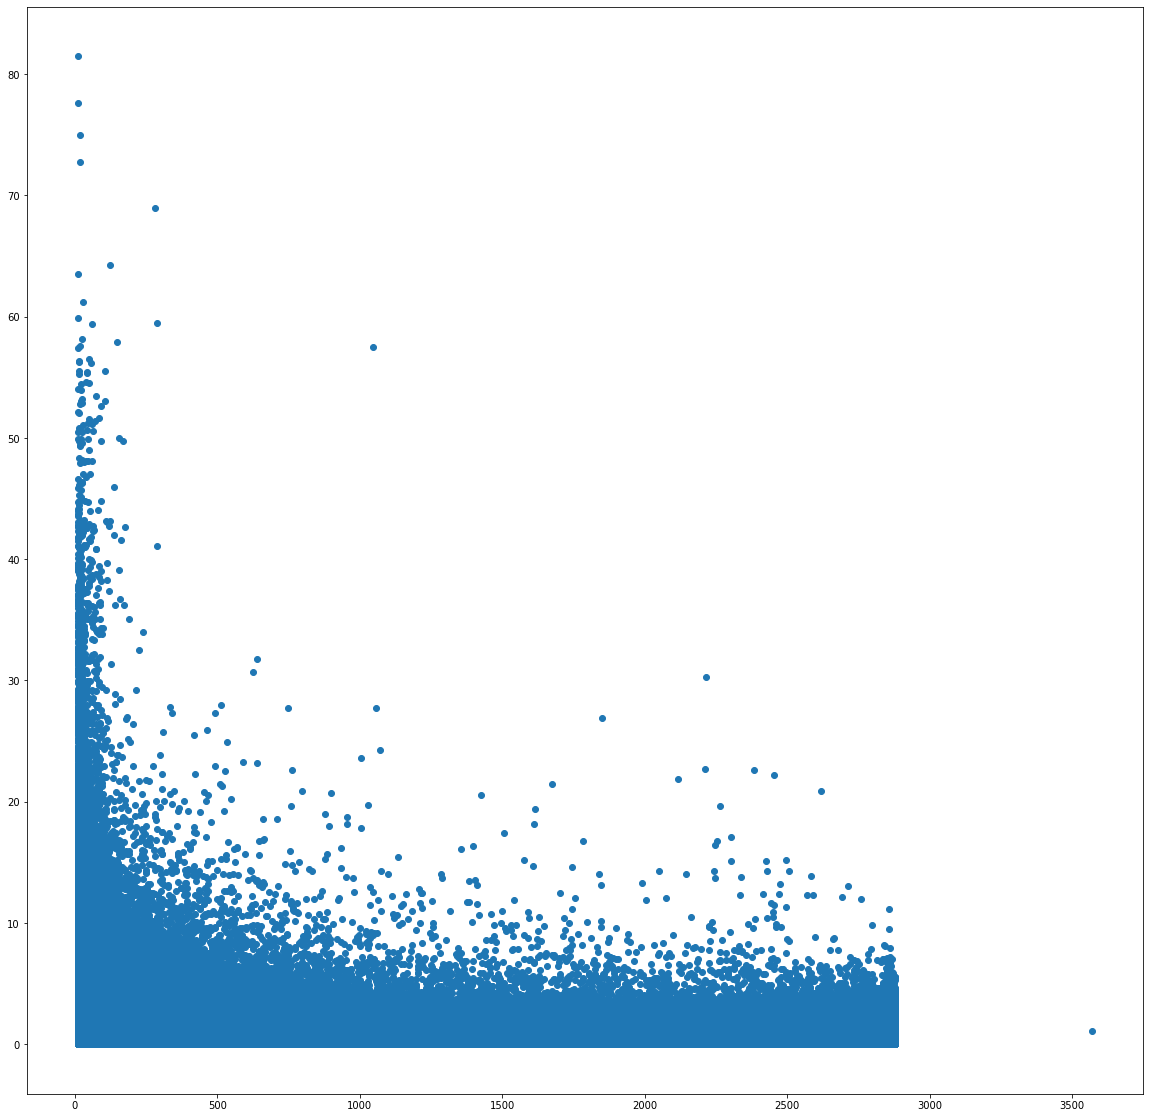

In [117]:
from ckmeans import ckmeans
import re
import matplotlib.pyplot as plt

def create_clusters(city, num_inputs=20):
    files_15min = sorted(list(
        (BASEDIR / 'movie_15min' / city).glob('*_8ch_15min.h5')))[-40:-40+num_inputs]
    dates = sorted([re.search(r"([0-9]{4}-[0-9]{2}-[0-9]{2})", str(f)).group(1) for f in files_15min])
    data_days = np.empty((len(dates)*96, 495, 436, 8), dtype=float)
    data_days[:] = np.nan
    for i, date in enumerate(dates):
        data = load_h5_file(BASEDIR / 'movie_15min' / city / f"{date}_{city}_8ch_15min.h5")
        print(f'{date} values > 0: {(data > 0).sum()}')
        data_days[i*96:i*96+96] = data
    print(f'Total values > 0: {(data_days > 0).sum()}')
    progress = 0
    speed_clusters = np.zeros(shape=(495,436,4,5,2))
    for s, si in zip([1,3,5,7],[0,1,2,3]):
        for y in range(495):
            for x in range(436):
                progress += 1
                if progress % 10000 == 0:
                    print(f'\rProgress {progress}/{495*436*4}', end='')
                speeds = data_days[:, y, x, s]
                speeds = speeds[~np.isnan(speeds)]
                speeds = speeds.astype('float64')
                speeds = speeds / 255 * 120
                speeds = np.sort(speeds)
                if len(speeds) < 10:
                    continue
                cluts = ckmeans(speeds, 5)
                ccents = [[np.median(c), len(c)] for c in cluts]
                speed_clusters[y][x][si] = ccents
    write_data_to_h5(
        speed_clusters, BASEDIR / 'movie_speed_clusters' / city / "speed_clusters.h5",
        dtype=np.float64)
    return speed_clusters



def plot_speed_clusters(speed_clusters):
    sum_data = speed_clusters.sum(axis=(-3, -2 ,-1))
    with np.errstate(divide='ignore'):  # avoids division by zero error
        sum_data = np.where(sum_data > 1, np.log(sum_data), 0)
    plt.figure(figsize=(10,10))
    plt.imshow(sum_data)
    

def get_mean_speeds(speed_clusters):
#     print(speed_clusters[273, 230, 3, :, :])
    speeds = np.prod(speed_clusters, axis=4)
#     print(speeds[273, 230, 3, :])
    speeds = np.sum(speeds, axis=3)
#     print(speeds[273, 230, 3])
    vols = np.sum(speed_clusters, axis=3)
#     print(vols[273, 230, 3, :])
    vols = vols[:, :, :, 1]
#     print(vols[273, 230, 3])
#     mean_speeds = np.divide(speeds, vols)
    speeds = np.divide(speeds, vols)
    return speeds, vols
#     print(mean_speeds[273, 230, 3])
#     print()
#     return mean_speeds


def diff_speed_clusters(city, new_speed_clusters):
    old_speed_clusters = load_h5_file(BASEDIR / 'movie_speed_clusters' / city / "speed_clusters_old.h5")
#     old_ms = get_mean_speeds(old_speed_clusters)
#     new_ms = get_mean_speeds(new_speed_clusters)
#     diff_ms = np.absolute(old_ms - new_ms)
#     print(np.nanmean(diff_ms))
#     print(np.nanmax(diff_ms))
#     plt.figure(figsize=(12,6))
#     plt.hist(np.matrix.flatten(diff_ms), bins=50, log=True)
#     plt.figure(figsize=(12,6))
    old_ms, old_mv = get_mean_speeds(old_speed_clusters)
    old_ms = np.matrix.flatten(old_ms)
    old_mv = np.matrix.flatten(old_mv)
    new_ms, new_mv = get_mean_speeds(new_speed_clusters)
    new_ms = np.matrix.flatten(new_ms)
    new_mv = np.matrix.flatten(new_mv)
    plt.figure(figsize=(20,20))
#     plt.scatter(x=old_mv, y=old_ms)
#     plt.scatter(x=new_mv, y=new_ms)
    diff_ms = np.absolute(old_ms - new_ms)
    plt.scatter(x=old_mv, y=diff_ms)
    
    
diff_speed_clusters('madrid', speed_clusters_madrid)
# diff_speed_clusters('london', speed_clusters_london)

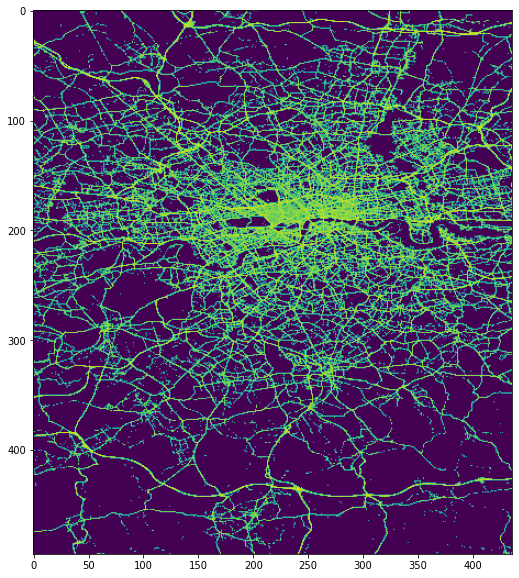

In [94]:
# speed_clusters_london = create_clusters('london')
speed_clusters_london = load_h5_file(BASEDIR / 'movie_speed_clusters' / 'london' / 'speed_clusters.h5')
plot_speed_clusters(speed_clusters_london)

In [93]:
# diff_speed_clusters('london', speed_clusters_london)

2021-10-11 values > 0: 9501798
2021-10-19 values > 0: 10181386
2021-10-20 values > 0: 10416855
2021-10-21 values > 0: 10571479
2021-10-22 values > 0: 11065129
2021-10-23 values > 0: 9791097
2021-10-24 values > 0: 8648629
2021-10-25 values > 0: 10157225
2021-11-02 values > 0: 9850121
2021-11-03 values > 0: 10138095
2021-11-04 values > 0: 10605240
2021-11-05 values > 0: 10992527
2021-11-06 values > 0: 9605984
2021-11-07 values > 0: 8554576
2021-11-08 values > 0: 10057552
2021-11-16 values > 0: 10102644
2021-11-17 values > 0: 10381698
2021-11-18 values > 0: 10616945
2021-11-19 values > 0: 11103351
2021-11-20 values > 0: 9768461
Total values > 0: 202110792
Progress 860000/215820

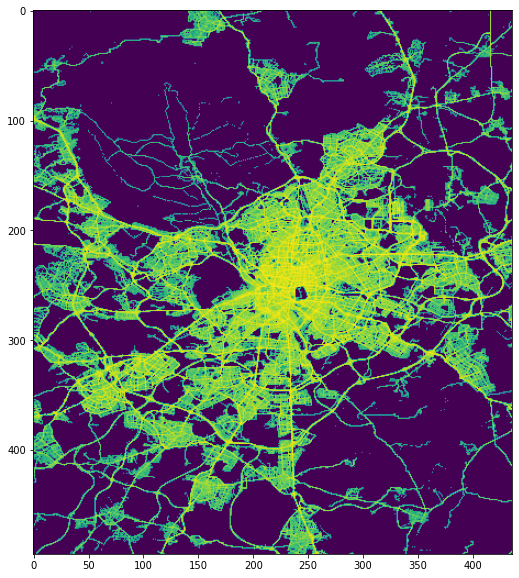

In [75]:
speed_clusters_madrid = create_clusters('madrid', 20)
# speed_clusters_madrid = load_h5_file(BASEDIR / 'movie_speed_clusters' / 'madrid' / 'speed_clusters.h5')
plot_speed_clusters(speed_clusters_madrid)

<ipython-input-87-e2655d4c3461>:54: RuntimeWarning: invalid value encountered in true_divide
  mean_speeds = np.divide(speeds, vols)


2.1549192073826546
81.48416289592761


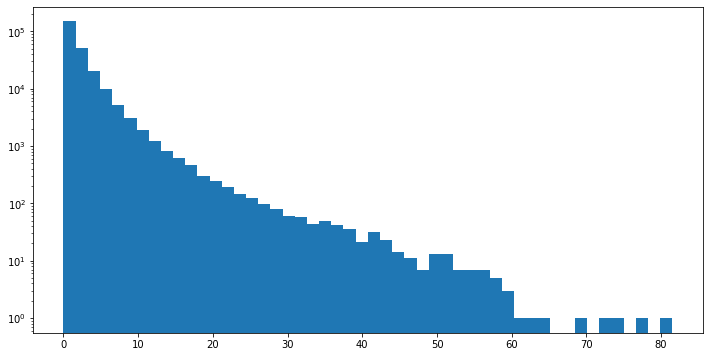

In [95]:
diff_speed_clusters('madrid', speed_clusters_madrid)

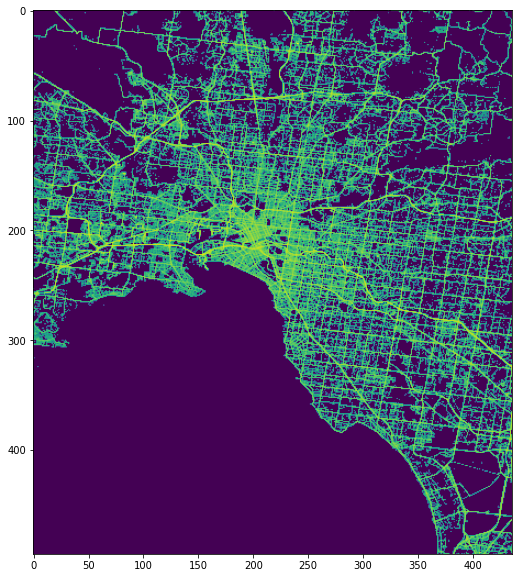

In [89]:
# speed_clusters_melbourne = create_clusters('melbourne')
speed_clusters_melbourne = load_h5_file(BASEDIR / 'movie_speed_clusters' / 'melbourne' / 'speed_clusters.h5')
plot_speed_clusters(speed_clusters_melbourne)

In [91]:
# diff_speed_clusters('melbourne', speed_clusters_melbourne)

### Intersecting Cells

In [58]:
def is_edge_geometry_reversed(nodes_dict, u, v, line):
    line = list(line.coords)
    un = nodes_dict[u]
    un = (un['x'], un['y'])
    vn = nodes_dict[v]
    vn = (vn['x'], vn['y'])
    if line[0] == un and line[-1] == vn:
        return False
    else:
        return True

    
def get_intersecting_cells(line, oneway, geometry_reversed, lat_min, lon_min):
    oneway = str(oneway) == 'True'
    # Add an additional point every 30m to make sure we catch all cells
    step_size = 0.0003
    lc = [line.interpolate(d) for d in np.arange(0, line.length+step_size, step_size)]
    line = LineString(lc)
    # Compute the intersecting cells in the corresponding geometry direction.
    intersecting_cells = get_intersecting_grid_cells(line, lon_min, lat_min, reverse=geometry_reversed)
    return intersecting_cells


def generate_intersecting_cells(city):
    lat_min, lat_max, lon_min, lon_max = get_latlon_bounds(city, verbose=True)
    
    nodes_df = pandas.read_parquet(ROAD_GRAPH_DIR / city / 'road_graph_nodes.parquet')
    nodes_dict = {}
    for node_id, x, y in zip(nodes_df['node_id'], nodes_df['x'], nodes_df['y']):
        nodes_dict[node_id] = {'x': x, 'y': y}
    print(f'Loaded {len(nodes_dict)} nodes')
    
    geometries_df = geopandas.read_parquet(ROAD_GRAPH_DIR / city / 'road_graph_geometries.parquet')
    geometries_df = geometries_df[['u', 'v', 'geometry']]
    print(f'Loaded {len(geometries_df)} edge geometries')
    
    edges_df = pandas.read_parquet(ROAD_GRAPH_DIR / city / 'road_graph_edges.parquet')
    edges_df = geometries_df.merge(edges_df, on=['u', 'v'])
    edges_df
    print(f'Loaded {len(edges_df)} edges')
    
    edges_df['geometry_reversed'] = [
        is_edge_geometry_reversed(nodes_dict, u, v, line)
        for u, v, line in zip(edges_df['u'], edges_df['v'], edges_df['geometry'])
    ]
    print(f'{len(edges_df[edges_df["geometry_reversed"]])} have a reversed geometry')
    
    edges_df['intersecting_cells'] = [
        str(get_intersecting_cells(line, oneway, geometry_reversed, lat_min, lon_min))
        for line, oneway, geometry_reversed in zip(
            edges_df['geometry'], edges_df['oneway'], edges_df['geometry_reversed'])
    ]
    print(f'Done generating intersecting cells for {city}')
    return edges_df


def intersecting_cells_equal(icos, icns):
    if icos == 'None' or icns == 'None':
        return False
    if type(icos) == str:
        icos = sorted(eval(icos))
    if type(icns) == str:
        icns = sorted(eval(icns))
    if len(icos) != len(icns):
        return False
    for ico, icn in zip(icos, icns):
        if (ico[0] != icn[0]) or (ico[1] != icn[1]) or (ico[2] != icn[2]):  # x, y and h are int
            return False
        if abs(ico[3] - icn[3]) > 0.1:  # overlap fraction is float
            return False
    return True

def compare_intersecting_cells(old_cells_df, new_cells_df):
    if len(old_cells_df) != len(new_cells_df):
        print(f'New cell mappings length differs: {len(new_cells_df)} != {len(old_cells_df)}')
        return False
    df = old_cells_df.merge(new_cells_df, on=['u', 'v'], how='left')
    for u, v, icos, icns in zip(df['u'], df['v'], df['old_cells'], df['cells']):
        if not intersecting_cells_equal(icos, icns):
            print(f'Found cell mapping difference at {u},{v}\n{icos}\n!=\n{icns}')
            return False
    print('Found no cell mapping differences')
    return True

def check_and_update_cell_mapping(city, edges_df, overwrite=False):
    new_cells_df = edges_df[['u', 'v', 'intersecting_cells']]
    new_cells_df = new_cells_df.rename(columns={'intersecting_cells': 'cells'})
    cell_mapping_fn = ROAD_GRAPH_DIR / city / 'cell_mapping.parquet'
    if cell_mapping_fn.exists():
        old_cells_df = pandas.read_parquet(cell_mapping_fn)
        old_cells_df = old_cells_df.rename(columns={'cells': 'old_cells'})
        print(f'Comparing {len(new_cells_df)} new cell mappings with {len(old_cells_df)} '\
              f'existing ones in {cell_mapping_fn}')
        compare_intersecting_cells(old_cells_df, new_cells_df)
    if overwrite or not cell_mapping_fn.exists():
        print(f'Saving new cell mappings to {cell_mapping_fn}')
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
            new_cells_df.to_parquet(cell_mapping_fn, compression="snappy")


# edges_df = generate_intersecting_cells('london')
# check_and_update_cell_mapping('london', edges_df)

edges_df = generate_intersecting_cells('madrid')
check_and_update_cell_mapping('madrid', edges_df)

# edges_df = generate_intersecting_cells('melbourne')
# check_and_update_cell_mapping('melbourne', edges_df)

Bounds for madrid: (40.177, 40.672, -3.927, -3.491)
Loaded 63397 nodes
Loaded 121902 edge geometries
Loaded 121902 edges
2620 have a reversed geometry
Done generating intersecting cells for madrid
Comparing 121902 new cell mappings with 121902 existing ones in /Users/neun/data/t4c/2022_comp_data/prepare_speed_classes/road_graph/madrid/cell_mapping.parquet
Found cell mapping difference at 25377795,6199978294656620
[(264, 295, 3, 0.47320270594401775), (265, 294, 3, 0.28219291360570053), (265, 295, 3, 0.24460438045028177)]
!=
[(265, 295, 0, 0.24460438045028177), (264, 295, 0, 0.47320270594401775), (265, 294, 0, 0.28219291360570053)]


### Free Flow Speeds

In [185]:
# ATTENTION: also exists in prepare_training_data_cc.py, make sure to keep in sync
def free_flow_speed_limit(free_flow_kph, speed_limit_kph):
    if not free_flow_kph or np.isnan(free_flow_kph) or free_flow_kph < 20:
        free_flow_kph = 20
    if speed_limit_kph >= 5 and free_flow_kph > speed_limit_kph:
        free_flow_kph = speed_limit_kph
    # Reduce free flow to max 60% but not below, e.g. 32->20, 50->30, 80->48, 110->66
    free_flow_kph = max(free_flow_kph, speed_limit_kph*0.6)
    return free_flow_kph


def extract_merged_speed_clusters(speed_clusters, intersecting_cells):
    merged_speed_clusters = []
    for  i, (r,c,h, _) in enumerate(intersecting_cells):
        r = int(r)
        c = int(c)
        h = int(h)
        merged_speed_clusters.extend([list(x) for x in speed_clusters[r,c,h,:]])
    merged_speed_clusters = sorted(merged_speed_clusters)
    return np.array(merged_speed_clusters)

def get_free_flow(heading_speeds, speed_limit=-1, volume_threshold=0.2):
    lhs = len(heading_speeds)-1
    if heading_speeds[lhs, 0] < speed_limit:
        return heading_speeds[lhs, 0]
    num_speeds = sum(heading_speeds[:,1])
    if num_speeds == 0:
        return np.nan
    vol_num_speeds = 0
    for i in range(lhs,-1,-1):
        vol_num_speeds += heading_speeds[i, 1]
        if vol_num_speeds / num_speeds > volume_threshold:
            free_flow = heading_speeds[i, 0]
            return free_flow
    return np.nan

def extract_free_flow_kph(
    speed_clusters, intersecting_cells, oneway, speed_limit_kph=-1, debug=False):
    intersecting_cells = eval(intersecting_cells)
    if len(intersecting_cells) == 0:
        return -1
    # For two-way also add the opposite headings.
    all_intersecting_cells = intersecting_cells[:]
    if not oneway or oneway == 'False':
        for ic in intersecting_cells:
            all_intersecting_cells.append((ic[0],ic[1],invert_heading(int(ic[2])),ic[3]))
            
#     all_intersecting_cells = all_intersecting_cells[4:]
    
    # Aggregate the speed clusters.
    merged_speed_clusters = extract_merged_speed_clusters(speed_clusters, all_intersecting_cells)
    free_flow = get_free_flow(merged_speed_clusters, speed_limit_kph)
    if debug:
        print(speed_limit_kph)
        print(oneway)
        print(type(oneway))
        print(all_intersecting_cells)
        print(len(all_intersecting_cells))
        print(merged_speed_clusters)
        print(free_flow)
#     if False: #False for london, True for melbourne?
#         free_flow = free_flow_speed_limit(free_flow, speed_limit_kph)
    return free_flow


def generate_free_flow_edges(speed_clusters, df, city, use_speed_limit=True, debug=False):   
    if use_speed_limit:
        # speed_limit_kph = read_speed_limit_kph(f, parse_maxspeed=(self.city=='madrid'))
        df['free_flow_kph'] = [
            extract_free_flow_kph(speed_clusters, ic, oneway, speed_limit_kph, debug)
            for ic, oneway, speed_limit_kph in zip(
                df['intersecting_cells'], df['oneway'], df['speed_kph'])
        ]
    else:
        df['free_flow_kph'] = [
            extract_free_flow_kph(speed_clusters, ic, oneway, debug=debug)
            for ic, oneway in zip(df['intersecting_cells'], df['oneway'])
        ]
    print(f'{len(df[df["free_flow_kph"].isna()])}/{len(df)} edges in {city} have NaN freeflow')
    return df
    

def generate_free_flow(city, use_speed_limit=False):
    speed_clusters = load_h5_file(BASEDIR / 'movie_speed_clusters' / city / 'speed_clusters.h5')
    print(f'Loaded speed clusters {speed_clusters.shape} for {city}')
    df = pandas.read_parquet(ROAD_GRAPH_DIR / city / 'road_graph_edges.parquet')
    cell_df = pandas.read_parquet(ROAD_GRAPH_DIR / city / 'cell_mapping.parquet')
    cell_df = cell_df.rename(columns={'cells': 'intersecting_cells'})
    df = df.merge(cell_df, on=['u', 'v'])
#     df = pandas.read_parquet(ROAD_GRAPH_DIR / city / 'road_graph_cells.parquet')
    print(f'Loaded {len(df)} edges with intersecting cells for {city}')
    df = generate_free_flow_edges(speed_clusters, df, city, use_speed_limit=use_speed_limit)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
        rg_fn = ROAD_GRAPH_DIR / city / 'road_graph_freeflow.parquet'
        df.to_parquet(rg_fn, compression="snappy")
        print(f'Saved freeflow to {rg_fn}')
    return df


# edges_df = generate_free_flow('london', use_speed_limit=True)
# edges_df = generate_free_flow('madrid')
edges_df = generate_free_flow('melbourne')

# Loaded speed clusters (495, 436, 4, 5, 2) for london
# Loaded 132414 edges with intersecting cells for london
# 0/132414 edges in london have NaN freeflow
# Saved freeflow to /Users/neun/data/t4c/2022_comp_data/prepare_speed_classes/road_graph/london/road_graph_freeflow.parquet
# Loaded speed clusters (495, 436, 4, 5, 2) for madrid
# Loaded 121902 edges with intersecting cells for madrid
# 126/121902 edges in madrid have NaN freeflow
# Saved freeflow to /Users/neun/data/t4c/2022_comp_data/prepare_speed_classes/road_graph/madrid/road_graph_freeflow.parquet
# Loaded speed clusters (495, 436, 4, 5, 2) for melbourne
# Loaded 94871 edges with intersecting cells for melbourne
# 1086/94871 edges in melbourne have NaN freeflow
# Saved freeflow to /Users/neun/data/t4c/2022_comp_data/prepare_speed_classes/road_graph/melbourne/road_graph_freeflow.parquet

# 579260	579352	
# 579260	814333	
# tu, tv = (9160844995367865137, 623017680)
# generate_free_flow_edges(
#     edges_df[(edges_df['u'] == tu) & (edges_df['v'] == tv)], city, use_speed_limit=False, debug=True)

Loaded speed clusters (495, 436, 4, 5, 2) for melbourne
Loaded 94871 edges with intersecting cells for melbourne
2590/94871 edges in melbourne have NaN freeflow
Saved freeflow to /Users/neun/data/t4c/2022_comp_data/prepare_speed_classes/road_graph/melbourne/road_graph_freeflow.parquet


### Speed Classes

In [339]:
edges_df = geopandas.read_parquet(ROAD_GRAPH_DIR / city / 'road_graph_freeflow.parquet')
print(f'Loaded {len(edges_df)} edges with free flow speed')

Loaded 94871 edges with free flow speed


In [431]:
edges_df.head()

,u,v,parsed_maxspeed,speed_kph,importance,highway,oneway,lanes,tunnel,length_meters,counter_distance,intersecting_cells,free_flow_kph
0,579260,814333,60.0,60.0,1,tertiary,False,,,42.282559,4,"[(328, 369, 2, 0.5496548061545049), (327, 369,...",53.647059
1,579260,32999237,60.0,60.0,1,tertiary,False,,,362.328760,4,"[(327, 369, 0, 0.2574483242308298), (326, 370,...",53.647059
2,579260,579352,60.0,60.0,0,residential,False,,,109.032366,4,"[(328, 370, 2, 0.0), (327, 369, 0, 0.255896555...",53.647059
3,579265,32999151,80.0,80.0,3,primary,True,3,,456.919917,0,"[(326, 383, 3, 0.24165347111634866), (330, 383...",64.000000
4,579267,32075354,80.0,80.0,4,trunk,True,3,,15.440773,1,"[(305, 382, 2, 0.0), (305, 383, 0, 1.0), (305,...",48.000000


In [346]:
SegmentSpeedStats = namedtuple("SegmentSpeedStats", [
    "volumes", "speeds", "median_speeds", "median_speeds_kph", "mean_speeds", "mean_speeds_kph"])


def extract_segment_speeds(data_aggregated_day, intersecting_cells):
    vols = np.zeros(shape=(data_aggregated_day.shape[0],))
    speeds = np.zeros(shape=(len(intersecting_cells),data_aggregated_day.shape[0]))
    # ((row,column,heading,heading_volume,overlap))
    # heading_volume is the heatmap volume
    for  i, (r,c,h, _) in enumerate(intersecting_cells):
        r = int(r)
        c = int(c)
        h = int(h)
        vols += data_aggregated_day[:,r,c,2*h]
        # TODO: add speed weighting by overlap here?!
        speeds[i]= data_aggregated_day[:,r,c,2*h+1]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        median_speeds = np.nanmedian(speeds, axis=0)
        mean_speeds = np.nanmean(speeds, axis=0)
    median_speeds_kph = median_speeds/255*120
    mean_speeds_kph = mean_speeds/255*120
    return SegmentSpeedStats(
        vols, speeds, median_speeds, median_speeds_kph, mean_speeds, mean_speeds_kph)

def extract_sc_features(edges_df, date, data_aggregated_day, slot_offset=0):
    road_graph_size = len(edges_df)
    result_data = []
    slots = data_aggregated_day.shape[0]
    for i, u, v, intersecting_cells, free_flow_kph, speed_limit_kph in zip(
        range(road_graph_size), edges_df['u'], edges_df['v'],
        edges_df['intersecting_cells'], edges_df['free_flow_kph'], edges_df['speed_kph']
    ):
        speed_stats = extract_segment_speeds(data_aggregated_day, intersecting_cells)
        assert speed_stats.volumes.shape == (slots,), speed_stats.volumes.shape
        assert speed_stats.speeds.shape == (len(speed_stats.speeds), slots), speed_stats.speeds.shape
        for t in range(slots):
            median_speed = speed_stats.median_speeds[t]
            if np.isnan(median_speed) or median_speed == 0 or median_speed == 255:
                continue
            median_speed_kph = speed_stats.median_speeds_kph[t]
            if np.isnan(median_speed_kph) or median_speed_kph <= 0 or median_speed_kph >= 120:
                continue
            probe_volume = speed_stats.volumes[t]
            if np.isnan(probe_volume) or probe_volume <= 0:
                continue

            normalized_speed = free_flow_speed_limit(free_flow_kph, speed_limit_kph)
            congestion_factor = median_speed_kph / normalized_speed
            
            if u == 579260 and v == 814333:
                print((t, probe_volume, median_speed_kph, normalized_speed, congestion_factor, free_flow_kph, speed_limit_kph))
            
            # Low congestion factor (aka traffic jam) needs more volume to be trusted.
            # Otherwise could also just be a stopping car.
            if probe_volume < 5 and congestion_factor < 0.4:
                continue
            if probe_volume < 3 and congestion_factor < 0.8:
                continue
            if probe_volume < 1:
                continue

            volume_class = int(np.floor((np.clip(probe_volume, 1, 5) + 1) / 2) * 2 - 1)
            tt = slot_offset+t
            d = {
                'u': u, 'v': v, 'day': date, 't': tt,
                'volume_class': volume_class, 'median_speed_kph': median_speed_kph,
                'free_flow_kph': free_flow_kph
            }
            result_data.append(d)
        if (i+1) % 5000 == 0 or i >= road_graph_size-1:
            print(f'\rProgress {i+1}/{road_graph_size}', end='')
    return result_data

def generate_speed_class_edges(edges_df, date, city):
    fn = BASEDIR / 'movie_15min' / city / f'{date}_{city}_8ch_15min.h5'
    print(f'Processing {fn} ...')
    data_aggregated_day = load_h5_file(fn)
    data = extract_sc_features(edges_df, date, data_aggregated_day)
    return pandas.DataFrame.from_dict(data)


def generate_speed_classes(date, city):
    edges_df = geopandas.read_parquet(ROAD_GRAPH_DIR / city / 'road_graph_freeflow.parquet')
    print(f'Loaded {len(edges_df)} edges with free flow speed')
    return generate_speed_class_edges(edges_df, date, city)

# sc_df = generate_speed_classes('2019-07-01', 'london')
# sc_df = generate_speed_classes(edges_df[(edges_df['u'] == 539344006) & (edges_df['v'] == 8014860932)], '2019-07-01', 'london')
# sc_df.to_parquet(BASEDIR / 'speed_classes' / city / f'speed_classes_{date}.parquet', compression="snappy")
sc_df = generate_speed_classes('2020-06-01', 'melbourne')
sc_df

Loaded 94871 edges with free flow speed
Processing /Users/neun/data/t4c/2022_comp_data/prepare_speed_classes/movie_15min/melbourne/2020-06-01_melbourne_8ch_15min.h5 ...
(18, 1.0, 16.0, 48.0, 0.3333333333333333, 48.0, 60.0)
(28, 1.0, 17.88235294117647, 48.0, 0.37254901960784315, 48.0, 60.0)
(31, 2.0, 32.23529411764706, 48.0, 0.6715686274509803, 48.0, 60.0)
(33, 1.0, 8.470588235294118, 48.0, 0.17647058823529413, 48.0, 60.0)
(39, 3.0, 17.411764705882355, 48.0, 0.36274509803921573, 48.0, 60.0)
(49, 2.0, 27.294117647058822, 48.0, 0.5686274509803921, 48.0, 60.0)
(69, 1.0, 11.76470588235294, 48.0, 0.24509803921568626, 48.0, 60.0)
Progress 94871/94871

,u,v,day,t,volume_class,median_speed_kph,free_flow_kph
0,579260,32999237,2020-06-01,41,5,24.000000,48.705882
1,579260,32999237,2020-06-01,49,1,40.000000,48.705882
2,579260,32999237,2020-06-01,50,1,45.647059,48.705882
3,579260,32999237,2020-06-01,55,1,46.588235,48.705882
4,579260,579352,2020-06-01,33,1,33.882353,21.647059
...,...,...,...,...,...,...,...
837331,582715470712446711,9160220792,2020-06-01,61,1,49.882353,52.705882
837332,582715470712446711,9160220792,2020-06-01,63,3,24.000000,52.705882
837333,582715470712446711,9160220792,2020-06-01,65,1,50.352941,52.705882
837334,582715470712446711,9160220792,2020-06-01,68,1,40.941176,52.705882


In [342]:
dates = sorted([str(fp).split('/')[-1][:10] for fp in (BASEDIR / 'movie_15min' / city).glob('*8ch_15min.h5')])
dates

['2020-06-01',
 '2020-06-02',
 '2020-06-03',
 '2020-06-04',
 '2020-06-05',
 '2020-06-06',
 '2020-06-07',
 '2020-06-15',
 '2020-06-16',
 '2020-06-17',
 '2020-06-18',
 '2020-06-19',
 '2020-06-20',
 '2020-06-21',
 '2020-06-29',
 '2020-06-30',
 '2020-07-01',
 '2020-07-02',
 '2020-07-03',
 '2020-07-04',
 '2020-07-05',
 '2020-07-13',
 '2020-07-14',
 '2020-07-15',
 '2020-07-16',
 '2020-07-17',
 '2020-07-18',
 '2020-07-19',
 '2020-07-27',
 '2020-07-28',
 '2020-07-29',
 '2020-07-30',
 '2020-07-31',
 '2020-08-01',
 '2020-08-02',
 '2020-08-10',
 '2020-08-11',
 '2020-08-12',
 '2020-08-13',
 '2020-08-14',
 '2020-08-15',
 '2020-08-16',
 '2020-08-24',
 '2020-08-25',
 '2020-08-26',
 '2020-08-27',
 '2020-08-28',
 '2020-08-29',
 '2020-08-30',
 '2020-09-07',
 '2020-09-08',
 '2020-09-09',
 '2020-09-10',
 '2020-09-11',
 '2020-09-12',
 '2020-09-13',
 '2020-09-21',
 '2020-09-22',
 '2020-09-23',
 '2020-09-24',
 '2020-09-25',
 '2020-09-26',
 '2020-09-27',
 '2020-10-05',
 '2020-10-06',
 '2020-10-07',
 '2020-10-

In [344]:
for date in dates:
    sc_df = generate_speed_classes(edges_df, date)
    sc_fn = BASEDIR / 'speed_classes' / city / f'speed_classes_{date}.parquet'
    sc_fn.parent.mkdir(parents=True, exist_ok=True)
    sc_df.to_parquet(sc_fn, compression="snappy")
    print(f'Saved {len(sc_df)} speed_classes to {sc_fn}')

Processing /Users/neun/data/t4c/2022_comp_data/prepare_speed_classes/movie_15min/melbourne/2020-06-01_melbourne_8ch_15min.h5 ...
Progress 94871/94871Saved 837336 speed_classes to /Users/neun/data/t4c/2022_comp_data/prepare_speed_classes/speed_classes/melbourne/speed_classes_2020-06-01.parquet
Processing /Users/neun/data/t4c/2022_comp_data/prepare_speed_classes/movie_15min/melbourne/2020-06-02_melbourne_8ch_15min.h5 ...
Progress 94871/94871Saved 959835 speed_classes to /Users/neun/data/t4c/2022_comp_data/prepare_speed_classes/speed_classes/melbourne/speed_classes_2020-06-02.parquet
Processing /Users/neun/data/t4c/2022_comp_data/prepare_speed_classes/movie_15min/melbourne/2020-06-03_melbourne_8ch_15min.h5 ...
Progress 94871/94871Saved 987551 speed_classes to /Users/neun/data/t4c/2022_comp_data/prepare_speed_classes/speed_classes/melbourne/speed_classes_2020-06-03.parquet
Processing /Users/neun/data/t4c/2022_comp_data/prepare_speed_classes/movie_15min/melbourne/2020-06-04_melbourne_8ch_15

Progress 94871/94871Saved 910865 speed_classes to /Users/neun/data/t4c/2022_comp_data/prepare_speed_classes/speed_classes/melbourne/speed_classes_2020-07-27.parquet
Processing /Users/neun/data/t4c/2022_comp_data/prepare_speed_classes/movie_15min/melbourne/2020-07-28_melbourne_8ch_15min.h5 ...
Progress 94871/94871Saved 946126 speed_classes to /Users/neun/data/t4c/2022_comp_data/prepare_speed_classes/speed_classes/melbourne/speed_classes_2020-07-28.parquet
Processing /Users/neun/data/t4c/2022_comp_data/prepare_speed_classes/movie_15min/melbourne/2020-07-29_melbourne_8ch_15min.h5 ...
Progress 94871/94871Saved 964788 speed_classes to /Users/neun/data/t4c/2022_comp_data/prepare_speed_classes/speed_classes/melbourne/speed_classes_2020-07-29.parquet
Processing /Users/neun/data/t4c/2022_comp_data/prepare_speed_classes/movie_15min/melbourne/2020-07-30_melbourne_8ch_15min.h5 ...
Progress 94871/94871Saved 949119 speed_classes to /Users/neun/data/t4c/2022_comp_data/prepare_speed_classes/speed_clas

Progress 94871/94871Saved 848038 speed_classes to /Users/neun/data/t4c/2022_comp_data/prepare_speed_classes/speed_classes/melbourne/speed_classes_2020-09-21.parquet
Processing /Users/neun/data/t4c/2022_comp_data/prepare_speed_classes/movie_15min/melbourne/2020-09-22_melbourne_8ch_15min.h5 ...
Progress 94871/94871Saved 846702 speed_classes to /Users/neun/data/t4c/2022_comp_data/prepare_speed_classes/speed_classes/melbourne/speed_classes_2020-09-22.parquet
Processing /Users/neun/data/t4c/2022_comp_data/prepare_speed_classes/movie_15min/melbourne/2020-09-23_melbourne_8ch_15min.h5 ...
Progress 94871/94871Saved 834985 speed_classes to /Users/neun/data/t4c/2022_comp_data/prepare_speed_classes/speed_classes/melbourne/speed_classes_2020-09-23.parquet
Processing /Users/neun/data/t4c/2022_comp_data/prepare_speed_classes/movie_15min/melbourne/2020-09-24_melbourne_8ch_15min.h5 ...
Progress 94871/94871Saved 867716 speed_classes to /Users/neun/data/t4c/2022_comp_data/prepare_speed_classes/speed_clas

KeyboardInterrupt: 